# TERRA Colocolizes to Double Stranded Breaks (DSBs), esp. in G2
This project is the data analysis of Dr. Taghreed Mohammed Al Turki's PhD data, in continuation of Chris Nelson's(?) previous work. The objective is to eelucidate if TERRA locolizes to global DSBs, to telomeric DSB's, and which phase of the cell cycle does TERRA colocolize to telo DSBs. 

In [22]:
# handling data
import pandas as pd
import numpy as np

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value Stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

print("Setup Complete")

Setup Complete


In [23]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


# Setting up the data

We want the data to be read by the program environment so that we can run quick and accurate analysis further on.

In [24]:
### REMEBER TO SAVE AS CSV FOR GITHUB ###

#Data for Global DSB analyis
global_df = pd.read_excel('../Documents/global_DSB_TERRA.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['Distribution of TERRA Foci/Cell', 'Cell Condition']
                              )

global_df.set_index(['Distribution of TERRA Foci/Cell'])
global_df.dropna(axis=0, inplace=True) 

#global_df.columns
global_df.head()

,Distribution of TERRA Foci/Cell,Cell Condition
0,14,2Gy
1,24,2Gy
2,19,2Gy
3,43,2Gy
4,17,2Gy


In [25]:
### REMEBER TO SAVE AS CSV FOR GITHUB ###

#Data for Global DSB analyis
global_pivot_df = pd.read_excel('../Documents/global_DSB_TERRA.xlsx',
                    sheet_name=0,
                    skiprows = 0,
                    #usecols = ['Distribution of TERRA Foci/Cell', 'Cell Condition']
                              )

global_pivot_df.set_index(['2Gy'])
global_pivot_df.dropna(axis=0, inplace=True) 

#global_pivot_df.columns
global_pivot_df.head()

,2Gy,0Gy,2Gy & RNAseA+H,0Gy & RNAseA+H
0,14,2,1.0,8
1,24,2,0.0,5
2,19,1,3.0,5
3,43,0,1.0,8
4,17,11,1.0,6


In [26]:
#Data for telo DSB analyis
telo_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=6,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Colocolization','total_foci','foci_per_cell'
                               
                              ] 
                         )

telo_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
telo_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_df.columns()
telo_df.head()

,Cell_condition,Colocolization,total_foci,foci_per_cell
0,EN-T,FLAG v. TERRA,689.5,25.072727
1,TRF1,FLAG v. TERRA,651.5,21.716667
2,Empty,FLAG v. TERRA,9.5,0.904762
3,Untransfected,FLAG v. TERRA,0.0,0.000000
4,EN-T & RNAseA+H,FLAG v. TERRA,480.5,24.641026


In [27]:
#Data for telo DSB analyis
telo_coloc_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=7,
                    skiprows = 0,
                    usecols = ['Cell Condition', 'FLAG v. TERRA','FLAG v. TRF2 v. TERRA','TRF2 v. TERRA'
                               
                              ] 
                         )

telo_coloc_df.set_index(['Cell Condition'])#good way to fix "not in axis issue"
telo_coloc_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_coloc_df.columns()
telo_coloc_df.head()

,Cell Condition,FLAG v. TERRA,FLAG v. TRF2 v. TERRA,TRF2 v. TERRA
0,EN-T,25.072727,7.436364,0.181818
1,TRF1,21.716667,10.050000,0.616667
2,Empty,0.904762,1.857143,10.476190
3,Untransfected,0.000000,0.000000,0.000000
4,EN-T & RNAseA+H,24.641026,2.923077,0.179487


In [28]:
#Data for telo DSB analyis
telo_cell_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=8,
                    skiprows = 0,
                    usecols = ['Colocolization', 'EN-T','TRF1','Empty','Untransfected','EN-T & RNAseA+H',
                               'TRF1 & RNAseA+H','Empty & RNAseA+H','Untransfected & RNAseA+H'   
                              ] 
                         )

telo_cell_df.set_index(['Colocolization'])#good way to fix "not in axis issue"
telo_cell_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_cell_df.columns()
telo_cell_df.head()

,Colocolization,EN-T,TRF1,Empty,Untransfected,EN-T & RNAseA+H,TRF1 & RNAseA+H,Empty & RNAseA+H,Untransfected & RNAseA+H
0,FLAG v. TERRA,25.072727,21.716667,0.904762,0.000000,24.641026,11.380952,7.500000,0.0
1,FLAG v. TERRA,39.486486,32.428571,13.095238,0.000000,18.000000,29.051724,12.631579,0.0
2,FLAG v. TERRA,36.553191,35.602564,8.697674,0.000000,26.000000,26.741935,20.509091,0.0
3,FLAG v. TERRA,44.680851,42.129870,8.916667,8.666667,30.640000,39.086957,4.642857,0.0
4,FLAG v. TERRA,32.786885,37.803279,7.457143,0.000000,15.264706,18.382979,8.228571,0.0


In [29]:
# To look at the relationship betweeen cell accumulation and TERRA accumulation per phase
g2_df = pd.read_excel('../Documents/telomere_G2_DSB_TERRA.xlsx',
                    sheet_name=6,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Phase','TERRA Amount','Cell_Amount',
                               'TERRA_%_In_Phase','Cell_%_In_Phase'] 
                         )

g2_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
g2_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#g2_df.columns()
g2_df.head(6)

,Cell_condition,Phase,TERRA Amount,TERRA_%_In_Phase,Cell_Amount,Cell_%_In_Phase
0,Empty,G1,132.0,10.806386,9.0,11.920530
1,Empty,G1,346.5,23.467660,16.5,24.812030
2,Empty,G1,814.0,41.267427,50.5,49.029126
3,Empty,G1,437.0,20.349243,21.0,21.761658
4,Empty,G1,264.0,13.618777,16.0,17.391304
5,Empty,S,65.0,5.321326,2.0,2.649007


# TERRA Responds to Global DSBs
   - What the experiment is (e.g. what is it testing and how):
   - "To induce Global DSBs, U2OS cells were treated with 2 gy Gamma rays, recovered for 4 hours, fixed." 
   - "To evaluate the induction of TERRA in response to the Global DSBs, the fixed cells were stained with C-rich labeld PNA probe. The experiment was repeated and cells were treated with a cocktail of  Rnase H and A for the removal of TERRA foci (negative control)." 


## Bar Plot

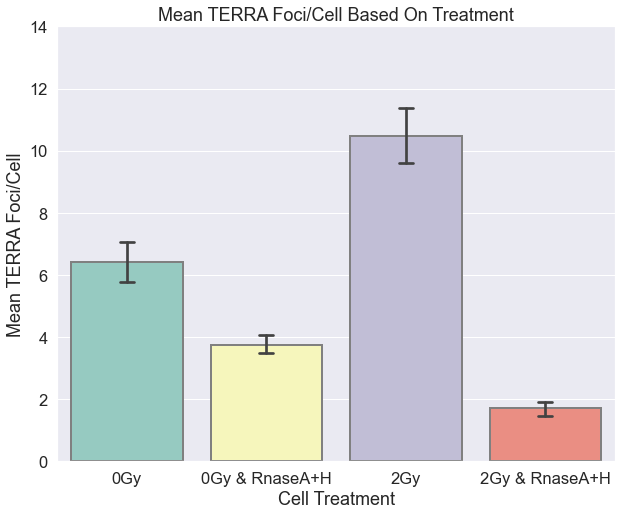

In [113]:
# Bar plot that uses all the values so we can get varience/stats measures
plt.figure(figsize=(10,8))
ax = sns.set(font_scale=1.5)
ax = sns.barplot(x=global_df['Cell Condition'],y='Distribution of TERRA Foci/Cell',
                 data=global_df,  palette="Set3", order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H'],
                 capsize=0.1, ci=68,
                )

ax.set(ylim=(0,14), xlabel='Cell Treatment', ylabel = 'Mean TERRA Foci/Cell')
plt.title('Mean TERRA Foci/Cell Based On Treatment')
plt.setp(ax.patches, linewidth=2, edgecolor=".5")

#plt.savefig(f'global_terra_bar.png', dpi=900, bbox_inches='tight')

## Stats

In [31]:
# one-way ANOVA's 

#Between all the groups
all_global_anova = stats.f_oneway(global_pivot_df['0Gy'],
               global_pivot_df['0Gy & RNAseA+H'],
               global_pivot_df['2Gy'],
               global_pivot_df['2Gy & RNAseA+H'])

#Between 0Gy and 2Gy
Zv2_global_anova = stats.f_oneway(global_pivot_df['0Gy'],
               global_pivot_df['2Gy'],
                )

#Between 0Gy and 0Gy & RNAseA+H
ZvZR_global_anova = stats.f_oneway(global_pivot_df['0Gy'],
               global_pivot_df['0Gy & RNAseA+H'],
               )

#Between 2Gy and 2Gy & RNAseA+H
Gy2v2R_global_anova = stats.f_oneway(global_pivot_df['2Gy'],
               global_pivot_df['2Gy & RNAseA+H'])

print( all_global_anova,'Between All\n',
       Zv2_global_anova,'0Gy vs. 2Gy\n',
       ZvZR_global_anova, '0Gy vs. 0Gy + Rnase\n',
       Gy2v2R_global_anova, '2Gy vs. 2Gy + Rnase\n'
     )

# All p<<0 indicates statistical significant difference between all the groups ****
# 0Gy vs. 2Gy P = 0.00042 indicates difference ***
# 0Gy vs. 0Gy + Rnase P=0.00027 indicates difference ***
# 2Gy vs. 2Gy + Rnase P=<<0 indicates difference ****

F_onewayResult(statistic=40.22130919965053, pvalue=3.673096649706062e-23) Between All
 F_onewayResult(statistic=12.807020720648879, pvalue=0.0004190395594394681) 0Gy vs. 2Gy
 F_onewayResult(statistic=13.687831185821716, pvalue=0.00026860018343309675) 0Gy vs. 0Gy + Rnase
 F_onewayResult(statistic=84.44535425121381, pvalue=2.1100880702536034e-17) 2Gy vs. 2Gy + Rnase



In [32]:
# perform Tukey HSD to confirm ANOVA results
global_tukey = pairwise_tukeyhsd(endog=global_df['Distribution of TERRA Foci/Cell'],
                          groups=global_df['Cell Condition'],
                          alpha=0.05)

print(global_tukey)

#Tukey HSD confirms the differences and includes that the +RNAse groups are not stat. different

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------
           0Gy 0Gy & RnaseA+H    -2.65 0.0085  -4.7985 -0.5015   True
           0Gy            2Gy   4.0667  0.001   1.9182  6.2152   True
           0Gy 2Gy & RnaseA+H     -4.7  0.001  -6.8485 -2.5515   True
0Gy & RnaseA+H            2Gy   6.7167  0.001   4.5682  8.8652   True
0Gy & RnaseA+H 2Gy & RnaseA+H    -2.05 0.0678  -4.1985  0.0985  False
           2Gy 2Gy & RnaseA+H  -8.7667  0.001 -10.9152 -6.6182   True
---------------------------------------------------------------------


## Box Plot

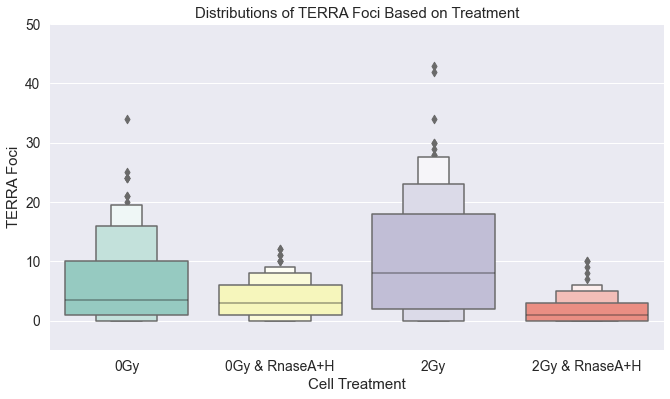

In [115]:
# A better representation of the distribution
f, ax = plt.subplots(figsize=(11, 6))
ax = sns.set(font_scale=1.25)
ax = sns.boxenplot(x=global_df['Cell Condition'],  palette="Set3", y='Distribution of TERRA Foci/Cell',
                 data=global_df, order = ['0Gy','0Gy & RnaseA+H','2Gy','2Gy & RnaseA+H'])

ax.set(ylim=(-5, 50), xlabel= "Cell Treatment", ylabel="TERRA Foci")
sns.despine(left=True, bottom=True)
plt.title('Distributions of TERRA Foci Based on Treatment')

#plt.savefig(f'global_terra_box.png', dpi=900, bbox_inches='tight')

# TERRA Locolizes to Telomeric DSBs
  - What the experiment is (e.g. what is it testing and how):
  - "To measure the colocalization of FLAG and TERRA  RNA FISH and Immunostaining to label FLAG in positively transfected cells and compare it to untransfected population."
  - to test wheather  this system allowed the formation of telomeric DSBs, cells were  fixed and immunostained to detect
    - a.FLAG  ( to label the positvely transfected cells).
    - b. yH2AX ( DSBs marker)
    - c. Edu ( S phase marker) FUCCI marker (G2 marker). 
    - The fixed cells were also stained with G-rich labeld PNA probe  to detect Telomeres (C-rich strands).


## Bar Plots

<Figure size 720x576 with 0 Axes>

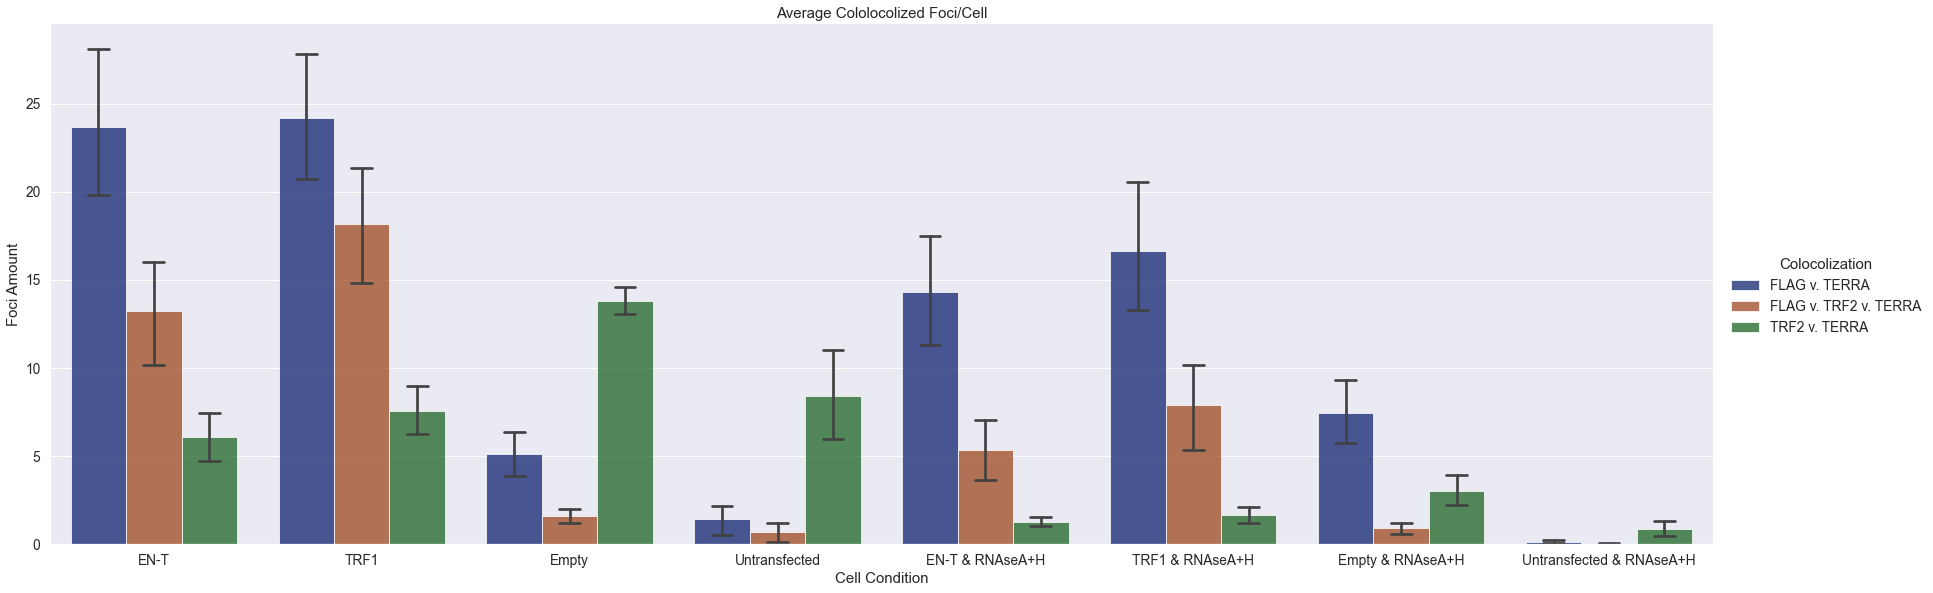

In [116]:
# Catagorical bar plot for
ax = sns.set(font_scale=1.25)
ax = plt.figure(figsize=(10,8))
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="foci_per_cell", hue="Colocolization",
    palette="dark", alpha=.75, height=8, aspect=3,
    capsize=0.1, ci=68
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Foci Amount")
g.legend.set_title("Colocolization")
plt.title("Average Cololocolized Foci/Cell")

#plt.savefig(f'telo_terra_whole.png', dpi=900, bbox_inches='tight')

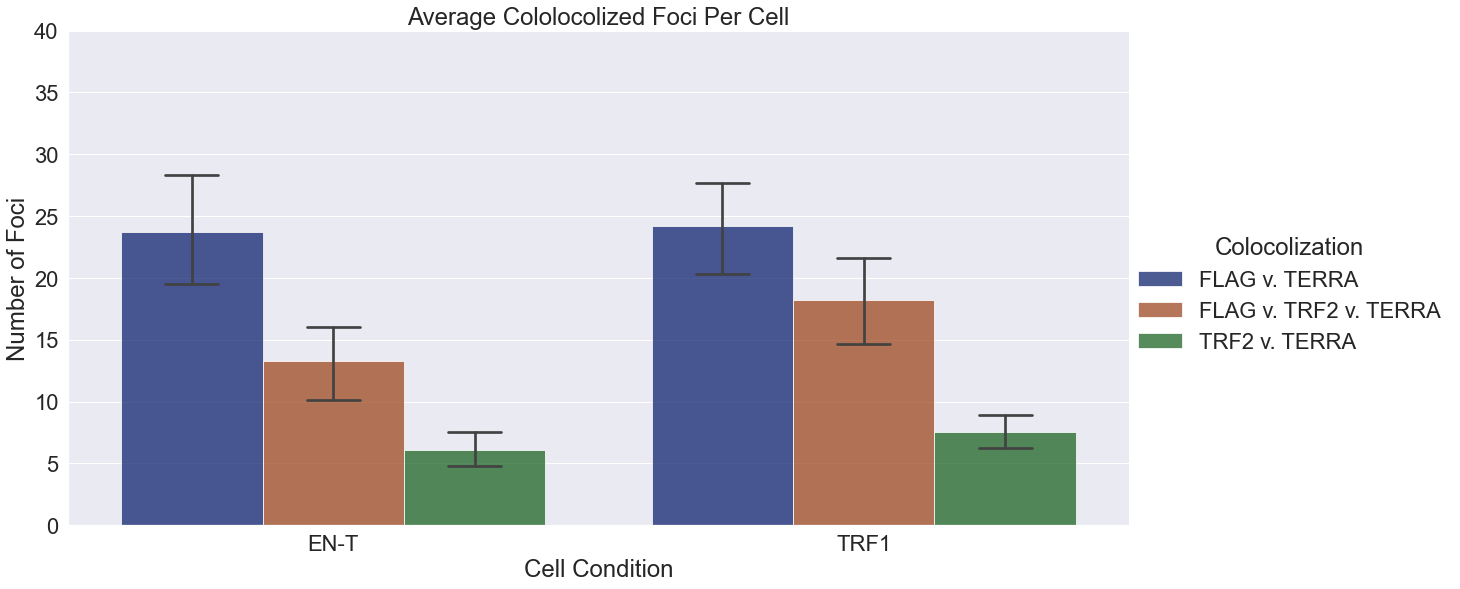

In [117]:
# Show that TERRA responds to DSB's from either EN-T and TRF1
ax = sns.set(font_scale=2)
#ax = plt.figure(figsize=(10,8))

g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="foci_per_cell", hue="Colocolization",
    capsize=0.1, ci=68, palette="dark", alpha=.75, height=8, aspect=2, order=["EN-T","TRF1"]
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Number of Foci")
g.legend.set_title("Colocolization")
g.set(ylim=(0,40))
plt.title("Average Cololocolized Foci Per Cell")

#plt.savefig(f'telo_terra_ENTvTRF1.png', dpi=900, bbox_inches='tight')

In [36]:
#ANOVA beetween the flags
a = stats.f_oneway(telo_cell_df['EN-T'].iloc[:10],
               telo_cell_df['TRF1'].iloc[:10],
                               )

#ANOVA Between the tricolocolizations
b =stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['TRF1'].iloc[11:20],
                                 )

#ANOVA between the TRF2's
c = stats.f_oneway(telo_cell_df['EN-T'].iloc[21:],
               telo_cell_df['TRF1'].iloc[21:],
                                 )
print(a,'Flag\n',b,'tri\n',c,'TRF2\n')

F_onewayResult(statistic=0.0074907920174264305, pvalue=0.9319852347203408) Flag
 F_onewayResult(statistic=1.0146976237782777, pvalue=0.32877203658344184) tri
 F_onewayResult(statistic=0.6622384330590622, pvalue=0.42771618130047206) TRF2



In [37]:
telo_cell_df.head()

,Colocolization,EN-T,TRF1,Empty,Untransfected,EN-T & RNAseA+H,TRF1 & RNAseA+H,Empty & RNAseA+H,Untransfected & RNAseA+H
0,FLAG v. TERRA,25.072727,21.716667,0.904762,0.000000,24.641026,11.380952,7.500000,0.0
1,FLAG v. TERRA,39.486486,32.428571,13.095238,0.000000,18.000000,29.051724,12.631579,0.0
2,FLAG v. TERRA,36.553191,35.602564,8.697674,0.000000,26.000000,26.741935,20.509091,0.0
3,FLAG v. TERRA,44.680851,42.129870,8.916667,8.666667,30.640000,39.086957,4.642857,0.0
4,FLAG v. TERRA,32.786885,37.803279,7.457143,0.000000,15.264706,18.382979,8.228571,0.0


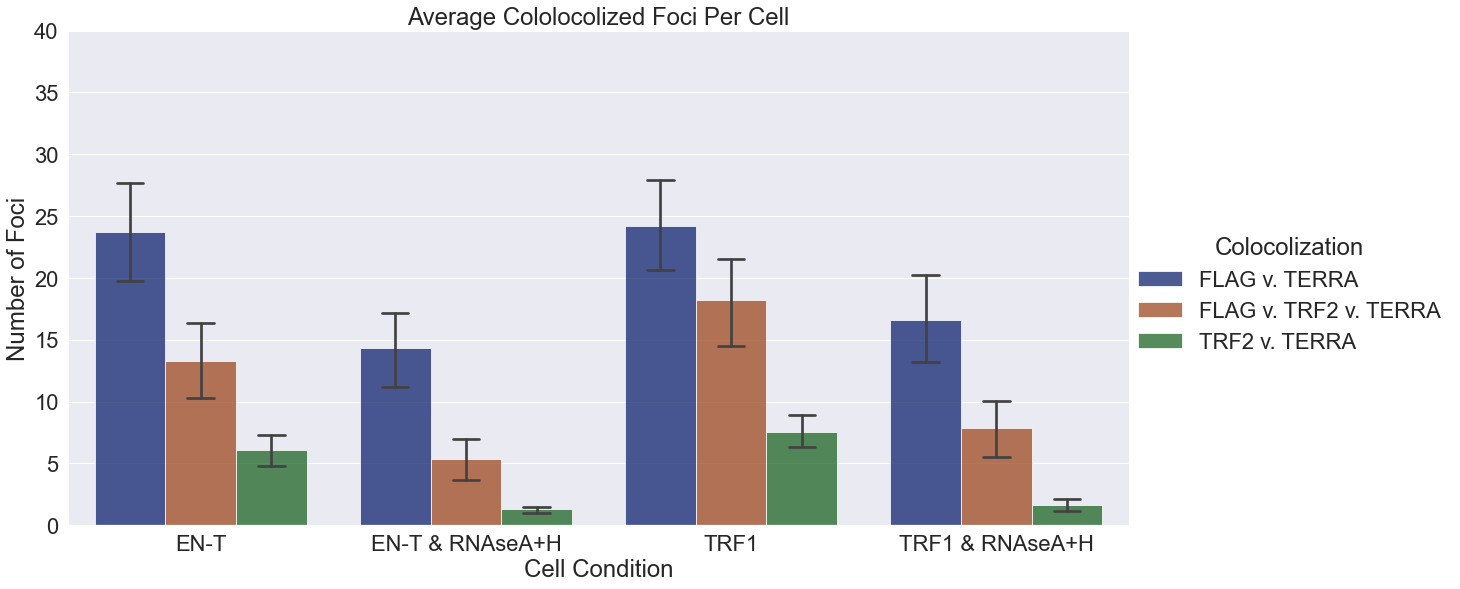

In [120]:
#Show that RNAseA+H reduces levels of TERRA, almost to scale which is intersting
ax = sns.set(font_scale=2)
#ax = plt.figure(figsize=(10,8))

g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="foci_per_cell", hue="Colocolization",
    capsize=0.1, ci=68, palette="dark", alpha=.75, height=8, aspect=2, 
    order=["EN-T","EN-T & RNAseA+H","TRF1","TRF1 & RNAseA+H"]
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Number of Foci")
g.legend.set_title("Colocolization")
g.set(ylim=(0,40))
plt.title("Average Cololocolized Foci Per Cell")

#plt.savefig(f'telo_terra_EvTwRNAse.png', dpi=900, bbox_inches='tight') #cant use "/" in the name

In [40]:
# ANOVA between FLAG v. T of the ENT groups
d = stats.f_oneway(telo_cell_df['EN-T'].iloc[:10],
               telo_cell_df['EN-T & RNAseA+H'].iloc[:10],
                                 )

# ANOVA between tri coloc of the ENT groups
e =stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['EN-T & RNAseA+H'].iloc[11:20],
                                 )

# ANOVA between TRF2 v. T of the ENT groups
f = stats.f_oneway(telo_cell_df['EN-T'].iloc[11:20],
               telo_cell_df['EN-T & RNAseA+H'].iloc[11:20],
                                 )

# ANOVA between FLAG v. T of the TRF1 groups
g = stats.f_oneway(telo_cell_df['TRF1'].iloc[:10],
               telo_cell_df['TRF1 & RNAseA+H'].iloc[:10],
                                 )

# ANOVA between tri coloc of the TRF1 groups
h = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['TRF1 & RNAseA+H'].iloc[11:20],
                                 )

# ANOVA between TRF2 v. T of the TRF1 groups
i = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['TRF1 & RNAseA+H'].iloc[11:20],
                                 )

print(d,'EN-T Flag\n',e,'EN-T tri\n',f,'EN-T TRF2\n',g,'TRF1 Flag\n',h,'TRF1 tri\n',i,'TRF1  TRF2\n')

F_onewayResult(statistic=2.999429378782151, pvalue=0.10039559636715745) EN-T Flag
 F_onewayResult(statistic=4.231719968983899, pvalue=0.05635779775743202) EN-T tri
 F_onewayResult(statistic=4.231719968983899, pvalue=0.05635779775743202) EN-T TRF2
 F_onewayResult(statistic=2.073295656872315, pvalue=0.16706359345413027) TRF1 Flag
 F_onewayResult(statistic=5.253377629178031, pvalue=0.035802190121200464) TRF1 tri
 F_onewayResult(statistic=5.253377629178031, pvalue=0.035802190121200464) TRF1  TRF2



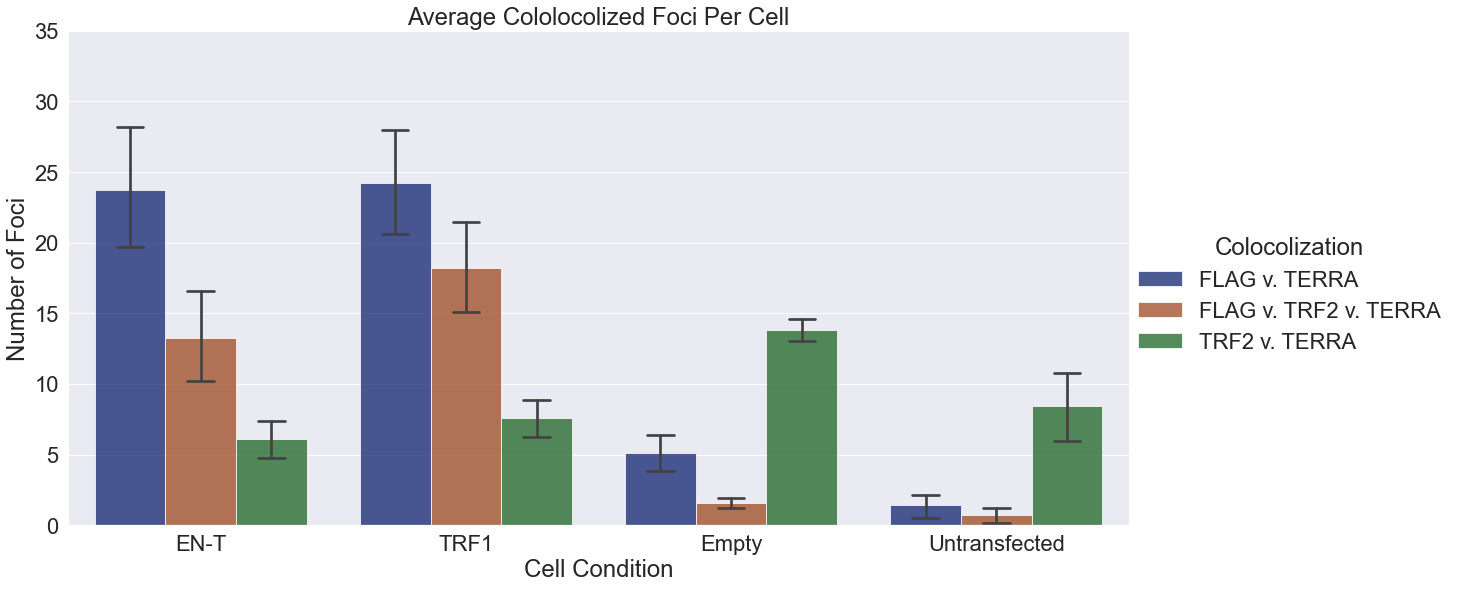

In [121]:
#Show the increased levels of TRF2-TERRA to support that free TERRA is recreuited to telo DSB's
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="foci_per_cell", hue="Colocolization",
    capsize=0.1, ci=68, palette="dark", alpha=.75, height=8, aspect=2, order=["EN-T","TRF1","Empty","Untransfected"],
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Number of Foci")
g.legend.set_title("Colocolization")
g.set(ylim=(0,35))
plt.title("Average Cololocolized Foci Per Cell")

#plt.savefig(f'telo_terra_EvTvEMPvUntrans.png', dpi=900, bbox_inches='tight')

In [146]:
# Only did b/w TRF1 and then Empty or Untrans because we say TRF1 and EN-T are not stat. diff

# T vs/ empty on FLag
j = stats.f_oneway(telo_cell_df['TRF1'].iloc[:10],
               telo_cell_df['Empty'].iloc[:10],
                                 )

# T vs/ empty on tri
k =stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )

# T vs/ empty on TRF2
l = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )

# T vs/ untrans on flag
m = stats.f_oneway(telo_cell_df['TRF1'].iloc[:10],
               telo_cell_df['Untransfected'].iloc[:10],
                                 )

# T vs/ untrans on tri
n = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )

# T vs/ untrans on TRF2
o = stats.f_oneway(telo_cell_df['TRF1'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )

print(j,'Empty Flag\n',k,'Empty tri\n',l,'Empty TRF2\n',m,'untrans Flag\n',n,'Untrans tri\n',o,'Untrans TRF2\n')

F_onewayResult(statistic=22.9040206361094, pvalue=0.00014790840055757597) Empty Flag
 F_onewayResult(statistic=21.048542733031045, pvalue=0.00030324510734208693) Empty tri
 F_onewayResult(statistic=21.048542733031045, pvalue=0.00030324510734208693) Empty TRF2
 F_onewayResult(statistic=34.732299828888685, pvalue=1.4029589978226206e-05) untrans Flag
 F_onewayResult(statistic=22.646952255330238, pvalue=0.00021351344139676102) Untrans tri
 F_onewayResult(statistic=22.646952255330238, pvalue=0.00021351344139676102) Untrans TRF2



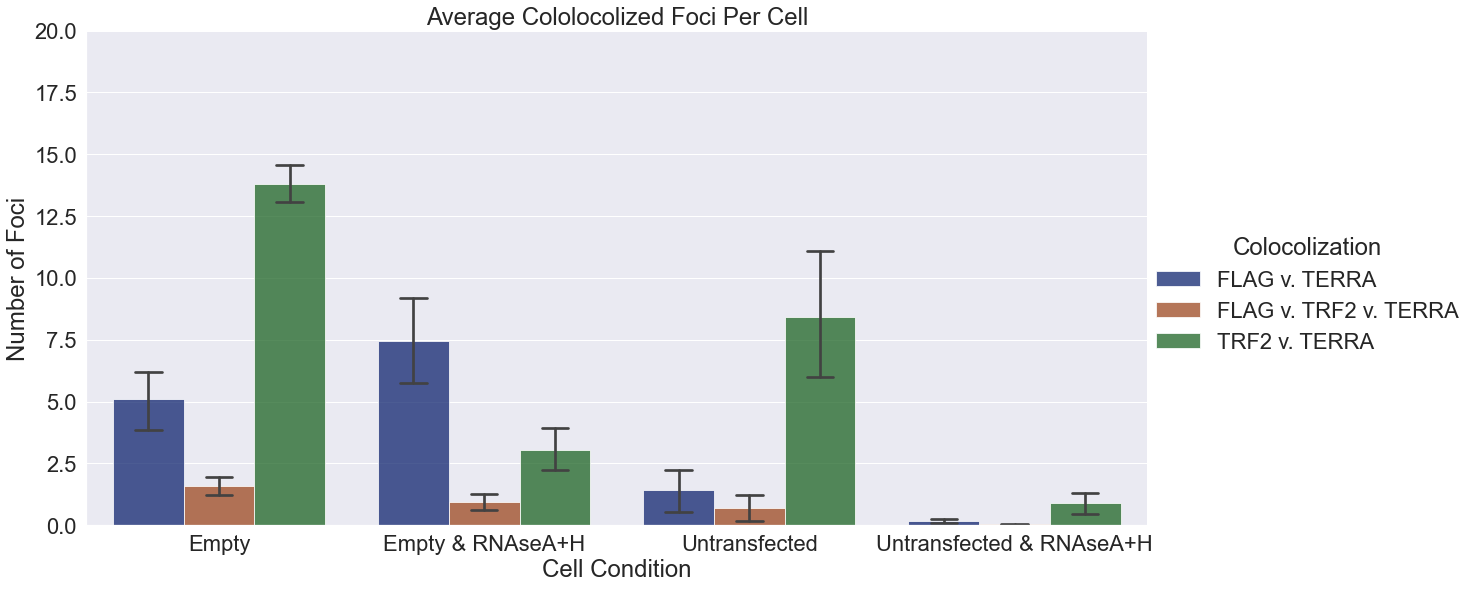

In [122]:
#Show the effects of +RNAse on our control cells
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="foci_per_cell", hue="Colocolization",
    capsize=0.1, ci=68, palette="dark", alpha=.75, height=8,
    aspect=2, order=["Empty","Empty & RNAseA+H","Untransfected","Untransfected & RNAseA+H"],
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Number of Foci")
g.legend.set_title("Colocolization")
g.set(ylim=(0,20))
plt.title("Average Cololocolized Foci Per Cell")

#plt.savefig(f'telo_terra_EMPvUntranswRNAse.png', dpi=900, bbox_inches='tight')

In [147]:
# Only did b/w TRF1 and then Empty or Untrans because we say TRF1 and EN-T are not stat. diff

# T vs/ empty on FLag
jj = stats.f_oneway(telo_cell_df['Empty & RNAseA+H'].iloc[:10],
               telo_cell_df['Empty'].iloc[:10],
                                 )

# T vs/ empty on tri
kk =stats.f_oneway(telo_cell_df['Empty & RNAseA+H'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )

# T vs/ empty on TRF2
ll = stats.f_oneway(telo_cell_df['Empty & RNAseA+H'].iloc[11:20],
               telo_cell_df['Empty'].iloc[11:20],
                                 )

# T vs/ untrans on flag
mm = stats.f_oneway(telo_cell_df['Untransfected & RNAseA+H'].iloc[:10],
               telo_cell_df['Untransfected'].iloc[:10],
                                 )

# T vs/ untrans on tri
nn = stats.f_oneway(telo_cell_df['Untransfected & RNAseA+H'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )

# T vs/ untrans on TRF2
oo = stats.f_oneway(telo_cell_df['Untransfected & RNAseA+H'].iloc[11:20],
               telo_cell_df['Untransfected'].iloc[11:20],
                                 )

print(jj,'Empty Flag\n',kk,'Empty tri\n',ll,'Empty TRF2\n',
      mm,'untrans Flag\n',nn,'Untrans tri\n',oo,'Untrans TRF2\n')


F_onewayResult(statistic=1.0306521089789853, pvalue=0.3234582435556208) Empty Flag
 F_onewayResult(statistic=0.9516985291022595, pvalue=0.3438072343591161) Empty tri
 F_onewayResult(statistic=0.9516985291022595, pvalue=0.3438072343591161) Empty TRF2
 F_onewayResult(statistic=2.157477614306295, pvalue=0.1591375523901747) untrans Flag
 F_onewayResult(statistic=1.5912050116123386, pvalue=0.22523578715482456) Untrans tri
 F_onewayResult(statistic=1.5912050116123386, pvalue=0.22523578715482456) Untrans TRF2



## Extra Stats

In [44]:
#ANOVA between all colocolizations
all_coloc_anova =stats.f_oneway(telo_coloc_df['FLAG v. TERRA'],
               telo_coloc_df['FLAG v. TRF2 v. TERRA'],
               telo_coloc_df['TRF2 v. TERRA'],
               )

#ANOVA between FlagT and Tri 
Fv3_coloc_anova = stats.f_oneway(telo_coloc_df['FLAG v. TERRA'],
               telo_coloc_df['FLAG v. TRF2 v. TERRA'],
               )

#ANOVA between TRF1T and tri
Tv3_coloc_anova = stats.f_oneway(telo_coloc_df['FLAG v. TRF2 v. TERRA'],
               telo_coloc_df['TRF2 v. TERRA'],
               )

#ANOVA between TRF1T and FlagT 
TvF_coloc_anova = stats.f_oneway(telo_coloc_df['FLAG v. TERRA'],
               telo_coloc_df['TRF2 v. TERRA'],
               )

print( all_coloc_anova,'Between All\n',
       Fv3_coloc_anova,'FlagT vs. tricolocolization\n',
       Tv3_coloc_anova, 'TRF2T vs. tricolocolization\n',
       TvF_coloc_anova, 'TRF2T vs. FlagT\n'
     )

#All sig diff except for TRF2 v. tri – shows that TRF2 drives the colocolization ––– could do SHAP if we wanted

F_onewayResult(statistic=10.940635828613273, pvalue=2.85268594584366e-05) Between All
 F_onewayResult(statistic=11.086851684615448, pvalue=0.001082125011747382) FlagT vs. tricolocolization
 F_onewayResult(statistic=0.31021807487536396, pvalue=0.5783345050786045) TRF2T vs. tricolocolization
 F_onewayResult(statistic=17.035335750219424, pvalue=5.922132154126668e-05) TRF2T vs. FlagT



In [45]:
# Tukey to confirm the colocolization differences
coloc_tukey = pairwise_tukeyhsd(endog=telo_df['foci_per_cell'],
                          groups=telo_df['Colocolization'],
                          alpha=0.05)

print(coloc_tukey)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
        group1                group2        meandiff p-adj  lower   upper  reject
---------------------------------------------------------------------------------
        FLAG v. TERRA FLAG v. TRF2 v. TERRA  -5.6226 0.001 -9.1012 -2.1441   True
        FLAG v. TERRA         TRF2 v. TERRA   -6.273 0.001 -9.7516 -2.7945   True
FLAG v. TRF2 v. TERRA         TRF2 v. TERRA  -0.6504 0.892 -4.1289  2.8282  False
---------------------------------------------------------------------------------


In [48]:
# Tukey to confirm the overall means of the different cells
cellcond_tukey = pairwise_tukeyhsd(endog=telo_df['foci_per_cell'],
                          groups=telo_df['Cell_condition'],
                          alpha=0.05)

print(cellcond_tukey)


               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1               group2          meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------
            EN-T          EN-T & RNAseA+H  -7.3605 0.0167 -13.9438 -0.7772   True
            EN-T                    Empty  -7.5286 0.0129 -14.1119 -0.9453   True
            EN-T         Empty & RNAseA+H -10.5545  0.001 -17.1378 -3.9711   True
            EN-T                     TRF1   2.2998    0.9  -4.2835  8.8831  False
            EN-T          TRF1 & RNAseA+H  -5.6402 0.1539 -12.2235  0.9431  False
            EN-T            Untransfected -10.8442  0.001 -17.4275 -4.2609   True
            EN-T Untransfected & RNAseA+H  -13.997  0.001 -20.5803 -7.4137   True
 EN-T & RNAseA+H                    Empty  -0.1681    0.9  -6.7515  6.4152  False
 EN-T & RNAseA+H         Empty & RNAseA+H   -3.194 0.7911  -9.7773  3.3893  False
 EN-T & RNAseA+H

## Distributions

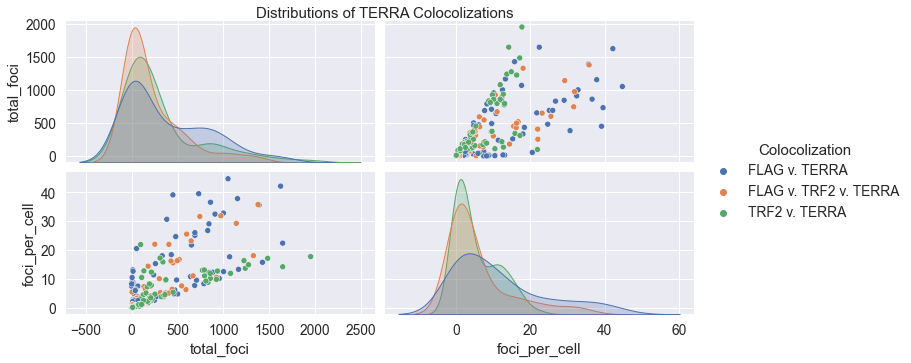

In [125]:
#Seeing the distribution of all the TERRA colocolizations
ax = sns.set(font_scale=1.25)

sns.pairplot(telo_df, hue="Colocolization", aspect=2, #palette="dark"
            )
plt.title("Distributions of TERRA Colocolizations", x=0, y=2.05)
#plt.legend(bbox_to_anchor=(2.01, 5),
           #borderaxespad=0)

#plt.savefig(f'telo_terra_coloc_distributions.png', dpi=900, bbox_inches='tight')

No handles with labels found to put in legend.


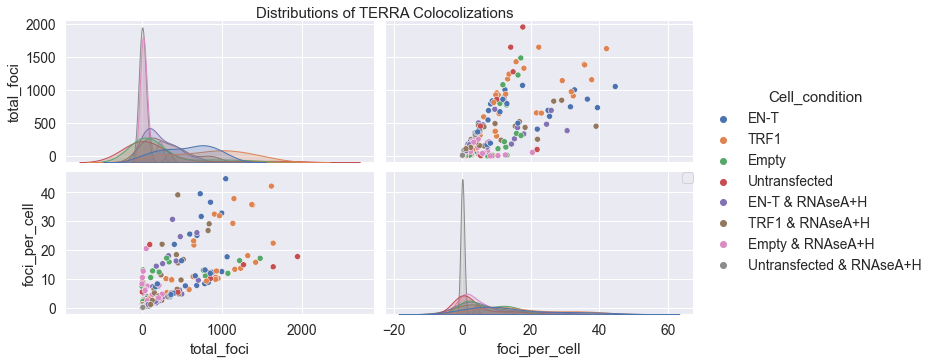

In [127]:
#Seeing if the cell transfection influences TERRA colocoliztion
ax = sns.set(font_scale=1.25)
sns.pairplot(telo_df, hue="Cell_condition", aspect=2, #palette="dark"
            )
plt.title('Distributions of TERRA Colocolizations', x=0, y=2.05)
plt.legend(bbox_to_anchor=(1, 1),
           borderaxespad=0)

#plt.savefig(f'telo_terra_cell_distributions.png', dpi=900, bbox_inches='tight')

# TERRA locolization to Telomeric DSBs accumulated in the G2 phase of the cell cycle
  - Same experiment but assesed based on cells transfected with:
      - "G1 (stained  ONLY  with DAPI), in S phase (stained with DAPI+EdU) and G2 ( cells stained with green FUCCI and DAPI) and then compared this to the number of TERRA foci in untransfected control."
      - "To measure the colocalization of FLAG and TERRA  RNA FISH and Immunostaining to label FLAG in positively transfected cells and compare it to untransfected population."
      - to test wheather  this system allowed the formation of telomeric DSBs, cells were  fixed and immunostained to detect
        - a.FLAG  ( to label the positvely transfected cells).
        - b. yH2AX ( DSBs marker)
        - c. Edu ( S phase marker) FUCCI marker (G2 marker). 
        - The fixed cells were also stained with G-rich labeld PNA probe  to detect Telomeres (C-rich strands).

## Bar Plots

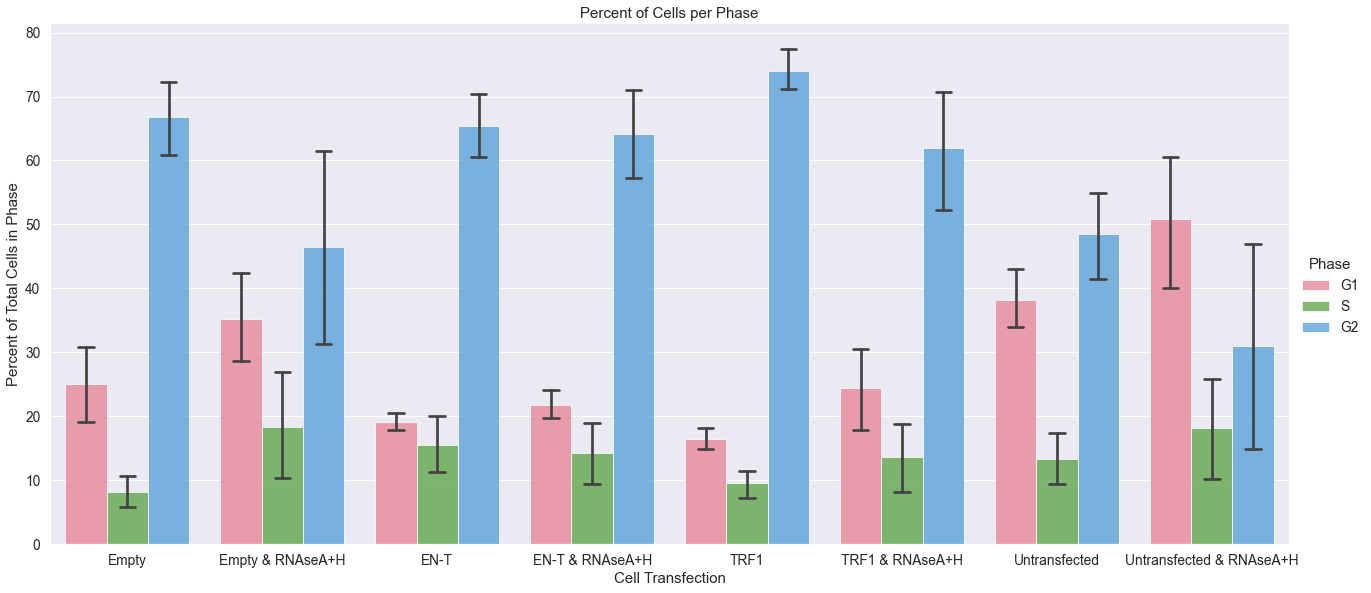

In [154]:
# Catagorical bar plot for percent of cells per phase
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="Cell_%_In_Phase", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2.25
)

g.despine(left=False)
g.set_axis_labels("Cell Transfection", "Percent of Total Cells in Phase")
g.legend.set_title("Phase")
plt.title("Percent of Cells per Phase")

plt.savefig(f'g2_cell_percent_whole.png', dpi=900, bbox_inches='tight')

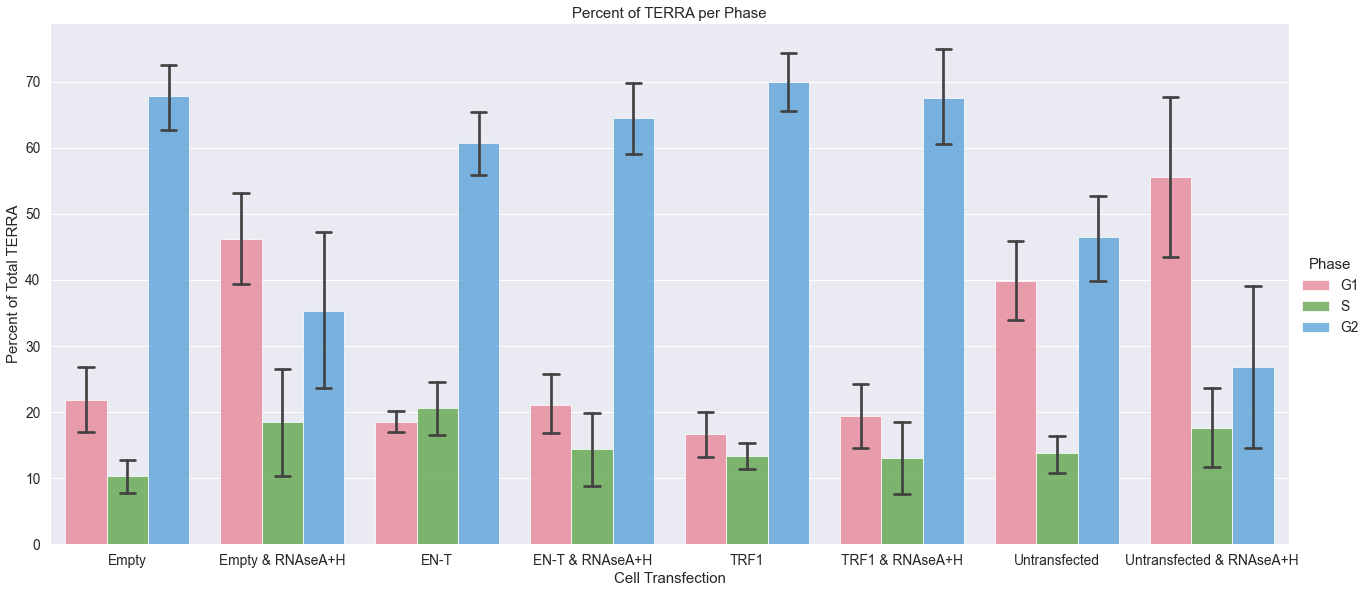

In [152]:
# Catagorical bar plot for percent of TERRA per phase
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA_%_In_Phase", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2.25
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "Percent of Total TERRA")
g.legend.set_title("Phase")
plt.title("Percent of TERRA per Phase")

#plt.savefig(f'g2_terra_percent_whole.png', dpi=900, bbox_inches='tight')

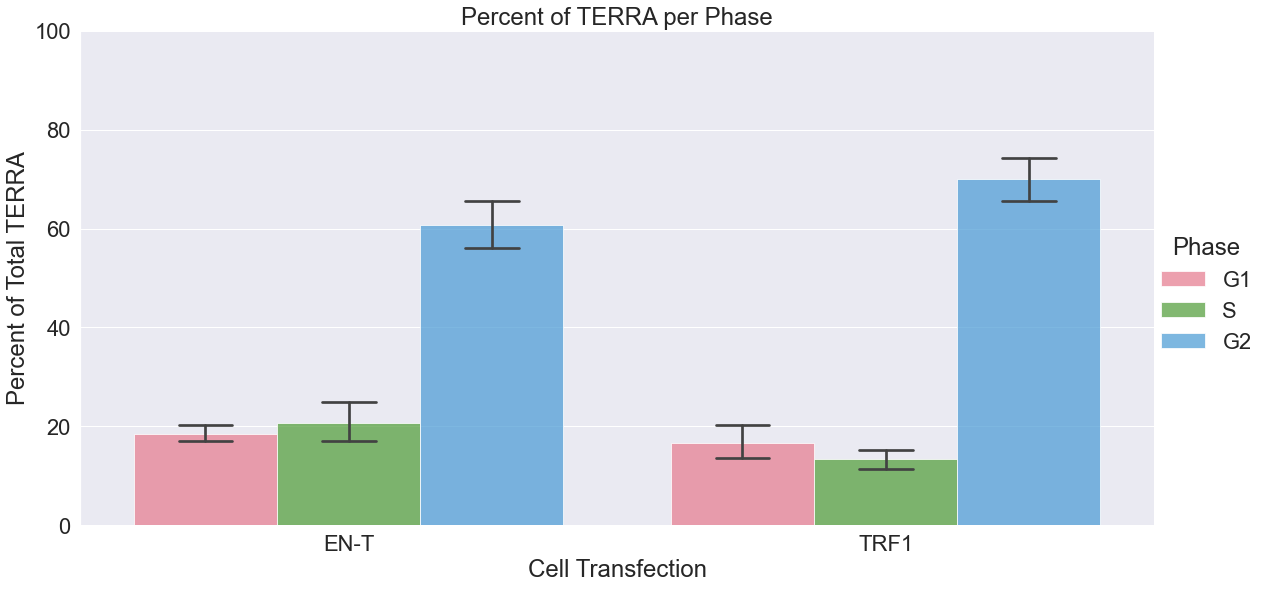

In [131]:
# Show that TERRA accumulates in G2 to Telo DSB's
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA_%_In_Phase", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2, order=['EN-T', 'TRF1'],
)

g.despine(left=False, bottom = True, right=True)
g.set_axis_labels("Cell Transfection", "Percent of Total TERRA")
g.legend.set_title("Phase")
plt.title("Percent of TERRA per Phase")
g.set(ylim=(0,100))

#plt.savefig(f'g2_ENTvTRF1.png', dpi=900, bbox_inches='tight')

In [54]:
# The rows that correspond to each cell type for .loc

#Empty [:14]
#Empty &RNAse [15:29]
#EN-T [30:44]
#EN-T & RNAseA+H [45:59]
#TRF1 [60:74]
#TRF1 & RNAseA+H [75:89]
#Untransfected[90:104]
#Untrans +Rnase [105:119]


#Compare G1 b/w EN-T and TRF1
p = stats.f_oneway(g2_df['TERRA_%_In_Phase'].loc[30:34],
               g2_df['TERRA_%_In_Phase'].loc[60:64],
                  )

#Compare S b/w EN-T and TRF1
q =stats.f_oneway(g2_df['TERRA_%_In_Phase'].loc[34:39],
               g2_df['TERRA_%_In_Phase'].loc[65:69],
                   )

#Compare G2 b/w EN-T and TRF1
r = stats.f_oneway(g2_df['TERRA_%_In_Phase'].loc[40:44],
               g2_df['TERRA_%_In_Phase'].loc[70:74],
                                 )
print(p,'G1\n',q,'S\n',r,'G2\n')

F_onewayResult(statistic=0.23921319348363598, pvalue=0.6379016049076873) G1
 F_onewayResult(statistic=2.830721812766869, pvalue=0.12676987549255353) S
 F_onewayResult(statistic=1.7615271939676311, pvalue=0.22106034817376802) G2



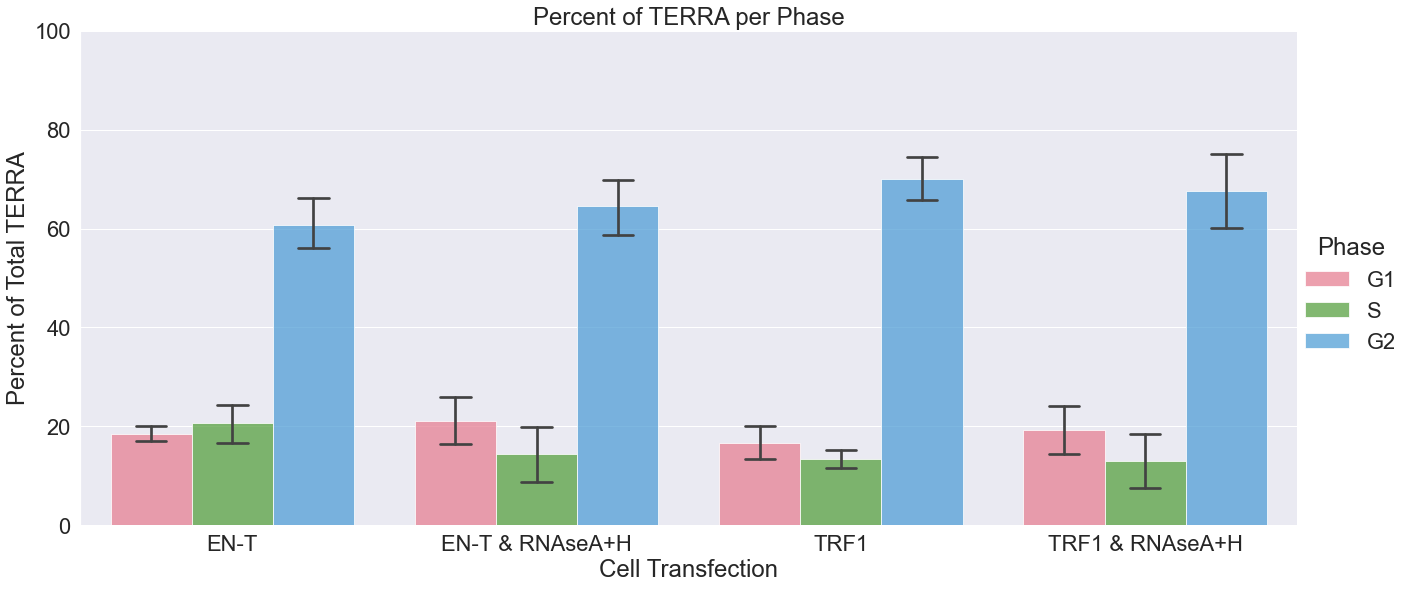

In [55]:
#Show the consistency that TERRA accumulates in G2 even when depleted
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA_%_In_Phase", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2.25,
    order=["EN-T","EN-T & RNAseA+H","TRF1","TRF1 & RNAseA+H"]
    
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "Percent of Total TERRA")
g.legend.set_title("Phase")
plt.title("Percent of TERRA per Phase")
g.set(ylim=(0,100))

###Note that this is PERCENT, amount of TERRA is below ####

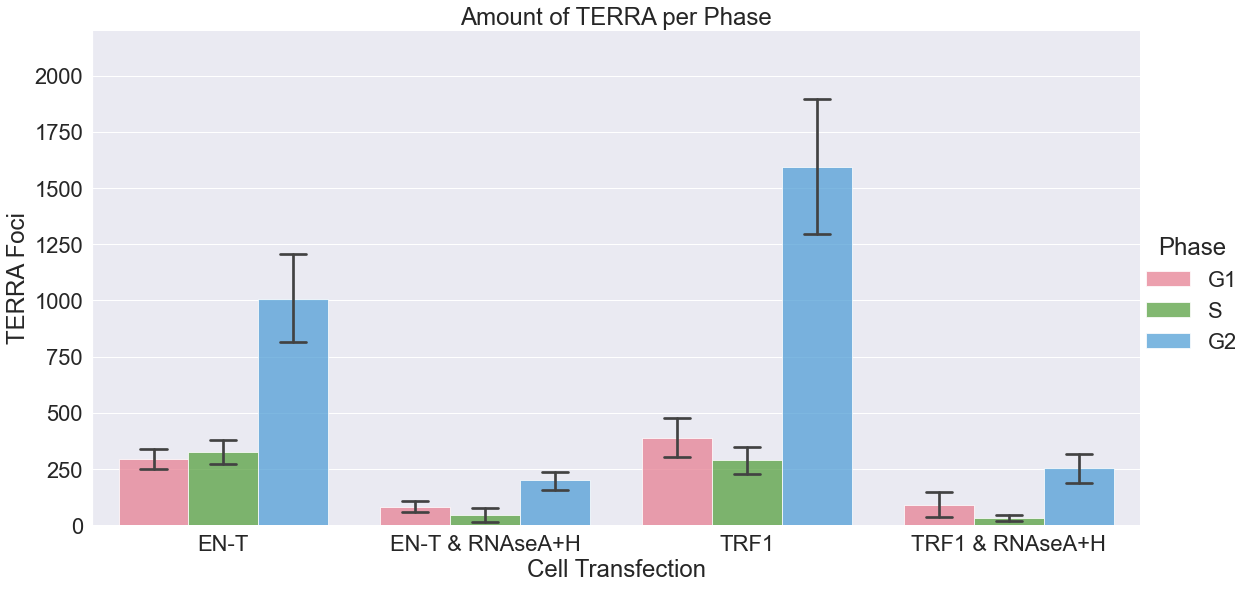

In [136]:
#Show the funky result that RNAse didn't deplete TERRA - consistent across the board
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA Amount", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2,
    order=["EN-T","EN-T & RNAseA+H","TRF1","TRF1 & RNAseA+H"]
    
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "TERRA Foci")
g.legend.set_title("Phase")
plt.title("Amount of TERRA per Phase")
g.set(ylim=(0,2200))

#plt.savefig(f'g2_EvTwRNAse.png', dpi=900, bbox_inches='tight')

In [57]:
#Compare G1 b/w EN-T and EN-T +RNASe 
s = stats.f_oneway(g2_df['TERRA Amount'].loc[30:44],
               g2_df['TERRA Amount'].loc[15:29],
                  )

#Compare TRF1 and TRF1 +RNASe 
t =stats.f_oneway(g2_df['TERRA Amount'].loc[60:74],
               g2_df['TERRA Amount'].loc[75:89],
                   )
                                 
print(s,'EN-T\n',t,'TRF1\n')

F_onewayResult(statistic=13.540340632075512, pvalue=0.0009848034754645887) EN-T
 F_onewayResult(statistic=10.055641228440658, pvalue=0.0036634212243499484) TRF1



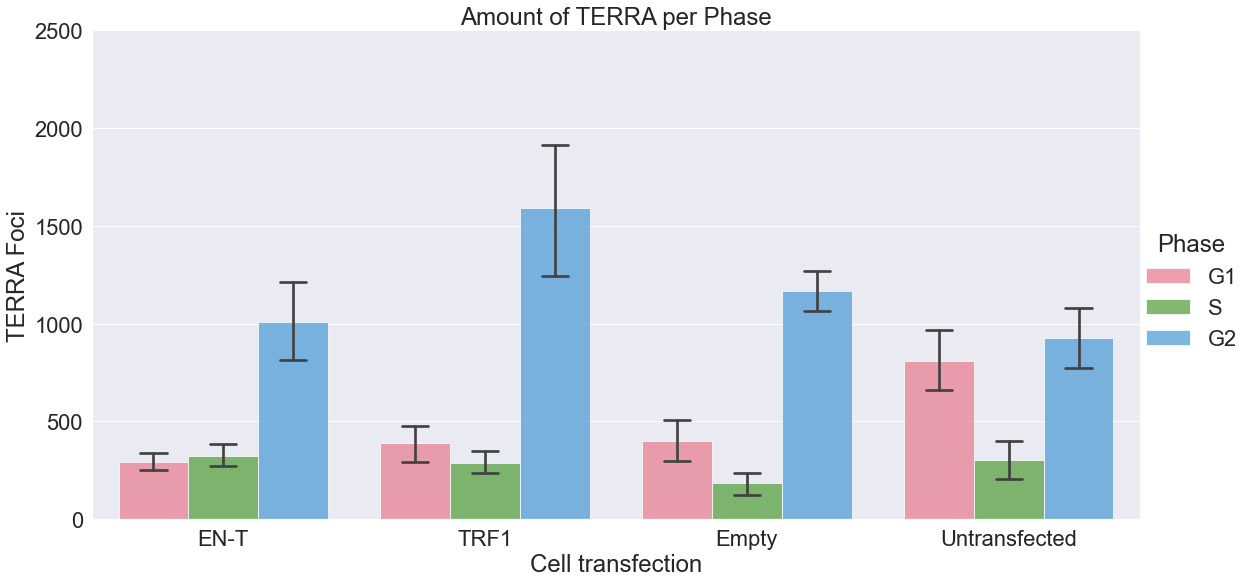

In [141]:
#Show the increased levels of TRF2-TERRA to support that free TERRA is recreuited to telo DSB's
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA Amount", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2,
    order=["EN-T","TRF1","Empty","Untransfected"],
)

g.despine(left=False)
g.set_axis_labels("Cell transfection", "TERRA Foci")
g.legend.set_title("Phase")
g.set(ylim=(0,2500))
plt.title("Amount of TERRA per Phase")

#plt.savefig(f'g2_EvTvEMPvUntrans.png', dpi=900, bbox_inches='tight')

In [155]:
#Compare Empty vs. TRF1
uu = stats.f_oneway(g2_df['TERRA Amount'].loc[60:74],
               g2_df['TERRA Amount'].loc[:14],
                  )

#Compare untrans vs. TRF1
vv =stats.f_oneway(g2_df['TERRA Amount'].loc[90:104],
               g2_df['TERRA Amount'].loc[60:74],
                   )

                                 
print(uu,'T v.empty\n',vv,'T v.Untrans\n')

F_onewayResult(statistic=0.5565154181739087, pvalue=0.46188523302078743) T v.empty
 F_onewayResult(statistic=0.12065314429277155, pvalue=0.7309246223384973) T v.Untrans



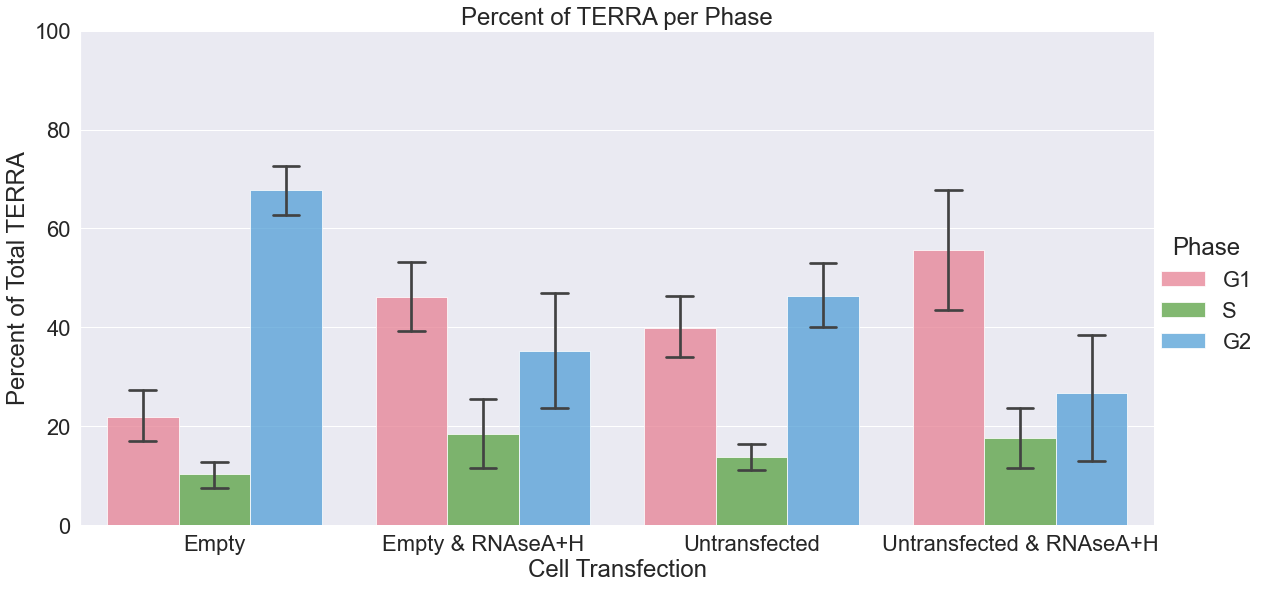

In [58]:
#Shows that with RNAse, TERRA accumulates in G1 for these cells
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA_%_In_Phase", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2,
    order=["Empty","Empty & RNAseA+H", "Untransfected","Untransfected & RNAseA+H"],  
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "Percent of Total TERRA")
g.legend.set_title("Phase")
plt.title("Percent of TERRA per Phase")
g.set(ylim=(0,100))

### Note that this is PERCENT of TERRA, amount of TERRA is below ###

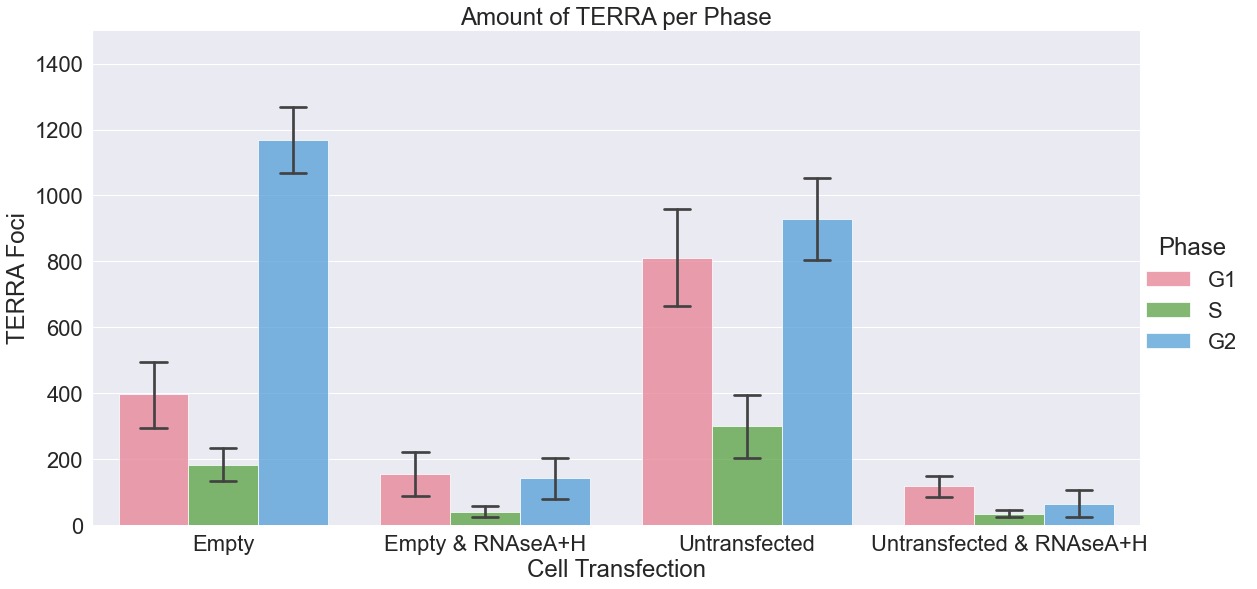

In [137]:
#Show that when looking at TERRA Amount +RNASe reduces TERRA
ax = sns.set(font_scale=2)
g = sns.catplot(
    data=g2_df, kind="bar",
    x="Cell_condition", y="TERRA Amount", hue="Phase",
    capsize=0.1, ci=68, palette="husl", alpha=.75, height=8, aspect=2, 
    order=["Empty","Empty & RNAseA+H","Untransfected","Untransfected & RNAseA+H"],  
)

g.despine(left=False, bottom = True)
g.set_axis_labels("Cell Transfection", "TERRA Foci")
g.legend.set_title("Phase")
plt.title("Amount of TERRA per Phase")
g.set(ylim=(0,1500))

#plt.savefig(f'g2_EmpvuntranswRNAse.png', dpi=900, bbox_inches='tight')

In [60]:
#Compare Empty vs. Emepty +RNASe
u = stats.f_oneway(g2_df['TERRA Amount'].loc[:14],
               g2_df['TERRA Amount'].loc[15:29],
                  )

#Compare untrans vs. untrans +RNASe 
v =stats.f_oneway(g2_df['TERRA Amount'].loc[90:104],
               g2_df['TERRA Amount'].loc[105:119],
                   )

#empty [:14]
#Empty &RNAse [15:29]
#EN-T [30:44]
#EN-T & RNAseA+H [45:59]
#TRF1 [60:74]
#TRF1 & RNAseA+H [75:89]
#Untransfected[90:104]
#Untrans +Rnase [105:119]
                                 
print(u,'empty\n',v,'Untrans\n')

F_onewayResult(statistic=13.360045653819414, pvalue=0.0010506304153717657) empty
 F_onewayResult(statistic=32.41484431533355, pvalue=4.189138378679088e-06) Untrans



## Distributions

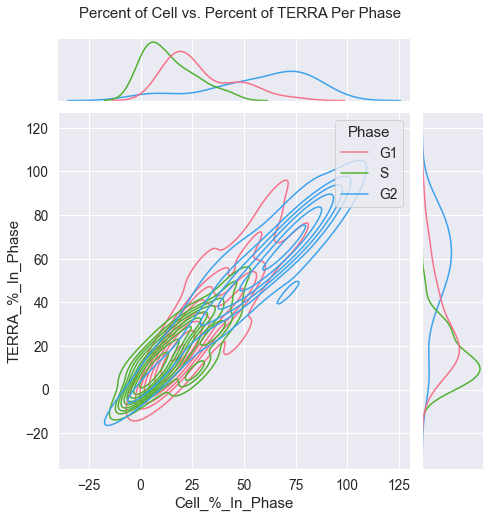

In [142]:
# Show that both the majority percent of cells and percent of TERRA accumulate in G2
ax = sns.set(font_scale=1.25)
g = sns.jointplot(
    data=g2_df,
    x="Cell_%_In_Phase", y="TERRA_%_In_Phase", hue="Phase",
    kind="kde",palette="husl",height=7
)

plt.title('Percent of Cell vs. Percent of TERRA Per Phase', x=-3, y=1.25)

#plt.savefig(f'g2_phase_single_distributions.png', dpi=900, bbox_inches='tight')

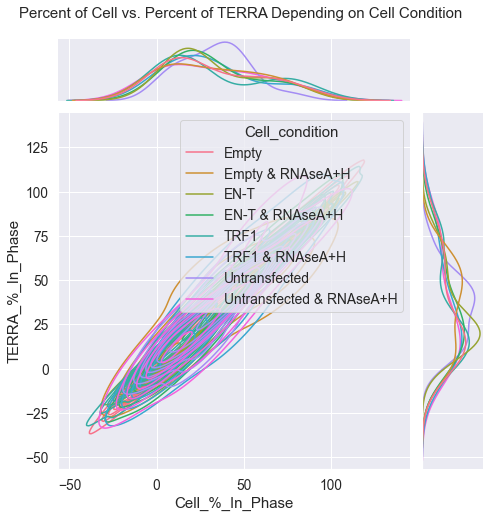

In [143]:
# Show that the accunulation in G2 is independent of the cell condition
ax = sns.set(font_scale=1.25)
g = sns.jointplot(
    data=g2_df,
    x="Cell_%_In_Phase", y="TERRA_%_In_Phase", hue="Cell_condition",
    kind="kde",palette="husl", height=7
)

plt.title('Percent of Cell vs. Percent of TERRA Depending on Cell Condition', x=-3, y=1.25)

#plt.savefig(f'g2_cell_single_distributions.png', dpi=900, bbox_inches='tight')

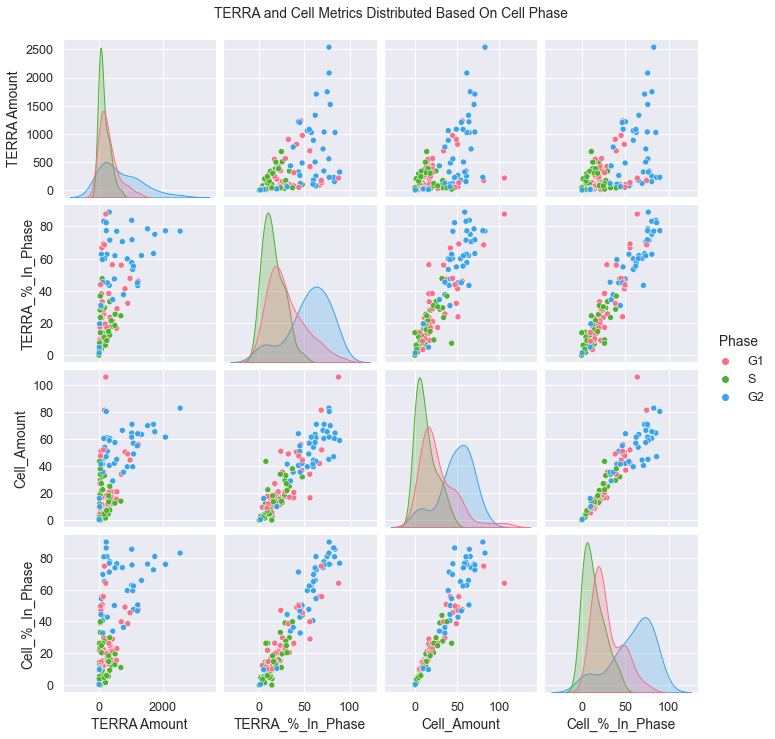

In [144]:
#Seeing the distribution of TERRA and cells through the cell cycle
ax = sns.set(font_scale=1.15)
sns.pairplot(g2_df, hue="Phase", aspect=1, palette="husl")
plt.title('TERRA and Cell Metrics Distributed Based On Cell Phase', x=-1, y=4.25)

#plt.savefig(f'g2_phase_whole_distributions.png', dpi=900, bbox_inches='tight')

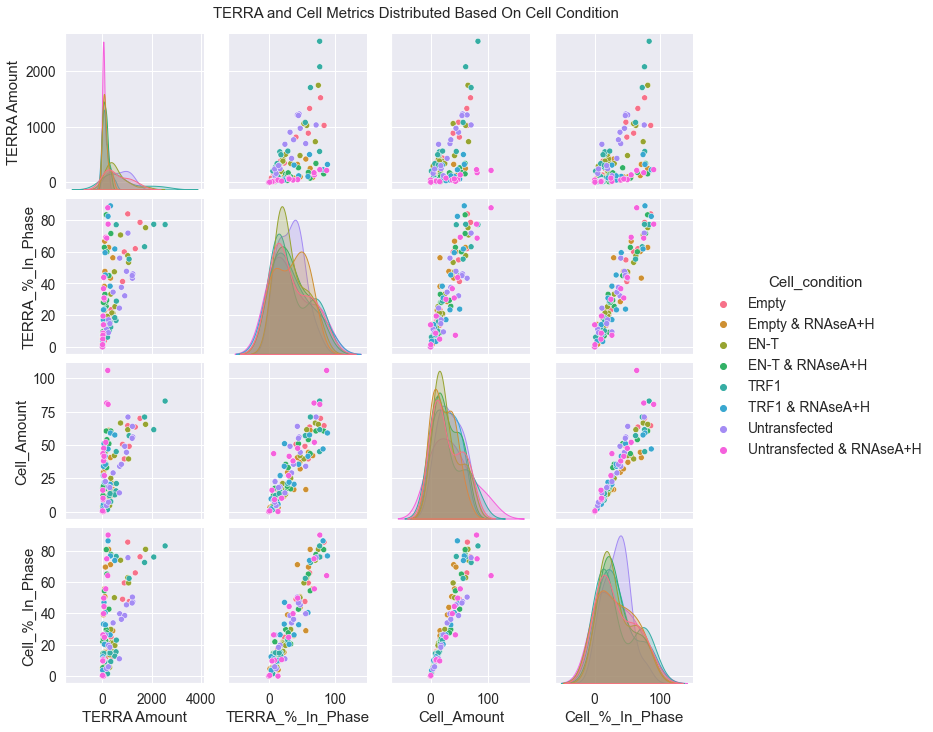

In [145]:
# Seeing if the cell transfection was responsible for the increased TERRA in G2
ax = sns.set(font_scale=1.25)
sns.pairplot(g2_df, hue="Cell_condition", aspect=1, palette="husl")
plt.title('TERRA and Cell Metrics Distributed Based On Cell Condition',x=-1, y=4.25)

#plt.savefig(f'g2_cell_whole_distributions.png', dpi=900, bbox_inches='tight')